Load Packages

In [1]:
import os
import sys
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

#pre-processing of text
import string
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import pandas as pd #to work with csv files
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.svm import OneClassSVM




In [2]:
# Overall goal is to handle imbalanced data.

Clean Twitter data

In [2]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def clean_text(str_list, lemmatize=True):
    clean_list = []

    for text in str_list:
        # Remove pound sign from hashtags
        text = re.sub(r'#', '', text)
        # Remove URLs
        text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]*", '', text)

        words = word_tokenize(text)
        clean_words = []

        lemmatizer = WordNetLemmatizer()  # Move lemmatizer initialization outside the loop
        
        for word in words:
            # Drop words with fewer than 2 characters and drop any punctuation "words", this will also get rid of the emojis
            if len(word) > 1 and re.match(r'^\w+$', word):
                if lemmatize:
                    word = lemmatizer.lemmatize(word)  # Apply lemmatization
                clean_words.append(word)
        
        # Remove stop words
        stop_words = set(nltk.corpus.stopwords.words('english'))
        clean_words = [word for word in clean_words if word.lower() not in stop_words]
        
        clean_text = ' '.join(clean_words)
        clean_list.append(clean_text)
    
    return clean_list

In [3]:
test_tweets = pd.read_csv('COVID19_Dataset-text_labels_only.csv')


#Filter tweets for train data (false)
false_tweets = pd.read_csv('Train.csv')
# Filter rows where the 'Origin' column is equal to 'Twitter'
false_tweets.query("label == 0")
#Changing Label to 1 to make it more consistent with the other dataset
false_tweets.loc[false_tweets['label'] == 0, 'label'] = 1

# Display the head of the datasets
print("COVID-19 Dataset:")
print(test_tweets.head())
print("\nFake News Dataset (Twitter Origin):")
print(false_tweets.head())



#Clean data 
test_tweets['clean tweet'] = clean_text(test_tweets['Tweet'])

false_tweets['clean text'] = clean_text(false_tweets['text'])
#View Data set
test_tweets.head()
false_tweets.head()



COVID-19 Dataset:
   Is_Unreliable    Category  \
0              1  1, 3, 6, 9   
1              1  1, 6, 8, 9   
2              1     1, 4, 9   
3              1        6, 8   
4              1     6, 8, 9   

                                               Tweet  
0  We are living in scary times in Canada. Gov’t ...  
1  Just as bad in Canada. In fact, our government...  
2  It was only a matter of time before the mainst...  
3  Russia's taking no chances: Foreigners infecte...  
4  Although there is now a presumptive confirmed ...  

Fake News Dataset (Twitter Origin):
                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      1
1  When I put this movie in my DVD player, and sa...      1
2  Why do people who do not know what a particula...      1
3  Even though I have great interest in Biblical ...      1
4  Im a die hard Dads Army fan and nothing will e...      1


,text,label,clean text
0,I grew up (b. 1965) watching and loving the Th...,1,grew 1965 watching loving Thunderbirds mate sc...
1,"When I put this movie in my DVD player, and sa...",1,put movie DVD player sat coke chip expectation...
2,Why do people who do not know what a particula...,1,people know particular time past wa like feel ...
3,Even though I have great interest in Biblical ...,1,Even though great interest Biblical movie wa b...
4,Im a die hard Dads Army fan and nothing will e...,1,Im die hard Dads Army fan nothing ever change ...


Data Distribution

reference for visualization: https://zablo.net/blog/post/twitter-sentiment-analysis-python-scikit-word2vec-nltk-xgboost/index.html

In [4]:
import plotly
from plotly import graph_objs

In [5]:
false = len(false_tweets[false_tweets['label']== 1])
dist = [
    graph_objs.Bar(
        x=["false tweets"],
        y=[false],
)]
plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Amount of False Tweets in Training Set")})

The false and true are about equal so need to make false a minority class

In [29]:
df = test_tweets
false = len(df[df["Is_Unreliable"] == 1])
true = len(df[df["Is_Unreliable"] == 0])
dist = [
    graph_objs.Bar(
        x=["false", "true"],
        y=[false, true],
)]
plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Sentiment type distribution in testing set")})

Creating imbalance class scenario

In [7]:
def create_imbalance(df, removal_count=250):
    # Shuffle the DataFrame to ensure randomness
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Get the count of tweets labeled as false
    false_count = len(df_shuffled[df_shuffled['Is_Unreliable'] == 1])
    
    # Determine the number of false tweets to remove
    remove_false_count = min(removal_count, false_count)
    
    # Remove false tweets
    removed_count = 0
    indexes_to_remove = []
    for index, row in df_shuffled.iterrows():
        if row['Is_Unreliable'] == 1:
            indexes_to_remove.append(index)
            removed_count += 1
            if removed_count >= remove_false_count:
                break
    
    df_balanced = df_shuffled.drop(indexes_to_remove)
    
    return df_balanced


In [8]:
less_false_test_data = create_imbalance(test_tweets, removal_count=250)

In [28]:
df = less_false_test_data
false = len(df[df["Is_Unreliable"] == 1])
true = len(df[df["Is_Unreliable"] == 0])
dist = [
    graph_objs.Bar(
        x=["false", "true"],
        y=[false, true],
)]
plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Sentiment type distribution in testing set")})

Intentially making false tweets the minority class. Reference: https://towardsdatascience.com/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a

Feature Engineering

Instead of tfidf, we are going to use the Glove feature extraction instead. The accuracy was pretty low when using this feature extraction and it could be based on the sophistication: ability to capture semantic meaning and contextual relationships. Additionally, we get to use a large dataset to derive 

## Word2Vec

In [10]:
from gensim.models import Word2Vec, KeyedVectors
# Load vectors directly from the file
import gensim
import numpy as np

# Load pre-trained Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [11]:
def embedding_feats(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0
        for token in tokens:
            if token in word2vec_model:
                feat_for_this += word2vec_model[token]
                count_for_this +=1
        feats.append(feat_for_this/count_for_this)        
    return feats

In [12]:
train_feats = embedding_feats(false_tweets['clean text'])
test_feats = embedding_feats(less_false_test_data['clean tweet'])

In [13]:
# Convert to dense matrices
dense_train_X = np.array(train_feats)
dense_test_X = np.array(test_feats)

In [14]:
print("Train feature shape:", dense_train_X.shape)
print("Test feature shape:", dense_test_X.shape)

Train feature shape: (40000, 300)
Test feature shape: (310, 300)


## Solely Train False Tweets
The 1 label or false tweets are not being recognize using this method. Less try to train solely the minority class in the training set.

In [15]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [16]:
# Define your data
X_train = dense_train_X
y_train = false_tweets['label']
X_test = dense_test_X
y_test = less_false_test_data['Is_Unreliable']


In [17]:
# Define embedding parameters
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 5000
EMBEDDING_DIM = 300

# Define the embedding layer
embedding_layer = Embedding(input_dim=MAX_NUM_WORDS,
                            output_dim=EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


c:\Users\rchlr\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [18]:
X_train.shape

(40000, 300)

In [22]:
from sklearn.metrics import precision_score, recall_score
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define a 1D CNN model class for one-class classification
cnnmodel = Sequential()
cnnmodel.add(embedding_layer)
cnnmodel.add(Conv1D(filters=16, kernel_size=10, activation='relu'))
cnnmodel.add(Dropout(0.5))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compile the model
cnnmodel.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

# Print model summary
cnnmodel.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)  # Changed filepath to .keras

# Train the model
history = cnnmodel.fit(X_train, y_train, epochs=20, validation_split=0.2,
                       callbacks=[early_stopping, model_checkpoint])

# Evaluate on test set
test_loss, test_acc = cnnmodel.evaluate(X_test, y_test)
print(f"Test accuracy with CNN: {test_acc:.3f}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 300, 300)         │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,500,000 (5.72 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,500,000 (5.72 MB)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.9935 - loss: 0.0163 - val_accuracy: 1.0000 - val_loss: 8.0198e-10
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 1.0000 - loss: 1.3749e-09 - val_accuracy: 1.0000 - val_loss: 8.0198e-10
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 1.0000 - loss: 1.3227e-09 - val_accuracy: 1.0000 - val_loss: 8.0198e-10
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 1.0000 - loss: 1.3491e-09 - val_accuracy: 1.0000 - val_loss: 8.0197e-10
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 1.0000 - loss: 1.3718e-09 - val_accuracy: 1.0000 - val_loss: 8.0194e-10
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 1.0000 - loss: 1.3421e-09 - val_accuracy: 1.0000 - val_loss: 8.0191e-10
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 1.0000 - loss: 1.3505e-09 - val_accuracy: 1.0000 - val_loss: 8.0182e-10
Epoch 8/20
1000/1000 ━━━

In [23]:
import numpy as np
from sklearn.metrics import classification_report


# Predict probabilities
y_pred = cnnmodel.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

# Generate classification report
report = classification_report(y_test, y_pred)

# Print the report
print(report)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       280
           1       0.00      0.00      0.00        30

    accuracy                           0.90       310
   macro avg       0.45      0.50      0.47       310
weighted avg       0.82      0.90      0.86       310



c:\Users\rchlr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\rchlr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\rchlr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



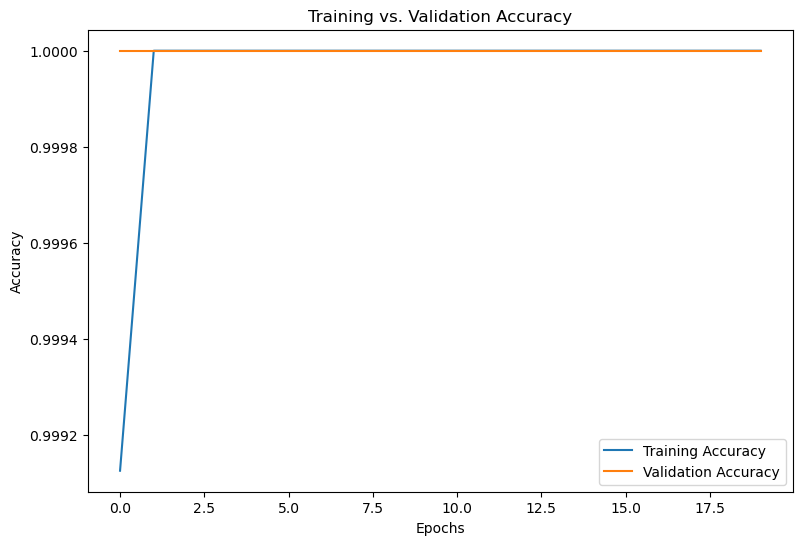

In [24]:
# Plot accuracy curves for training and validation sets
# Plot accuracy curves for training and validation sets
import pandas as pd
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()


plt.show()

## Visualization

In [25]:
from sklearn.decomposition import PCA

X = X_test

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [26]:
df = pd.DataFrame({
    'Feature 1': X_pca[:, 0],  # the first feature of dense_test_X
    'Feature 2': X_pca[:, 1],  # the second feature of dense_test_X
    'Binary Label': y_test,
    'one_class_cnn_prediction': y_pred,
})

# Display the DataFrame
print(df)

     Feature 1  Feature 2  Binary Label  one_class_cnn_prediction
0    -0.126024   0.105654             0                         0
1    -0.142881   0.065603             0                         0
4     0.002675   0.124332             0                         0
7    -0.088191  -0.004197             0                         0
9    -0.097154   0.105074             0                         0
..         ...        ...           ...                       ...
555  -0.170959  -0.103043             1                         0
556  -0.178091  -0.117607             1                         0
557  -0.043036   0.023733             1                         0
558  -0.043380  -0.016942             0                         0
559  -0.140105  -0.074618             1                         0

[310 rows x 4 columns]


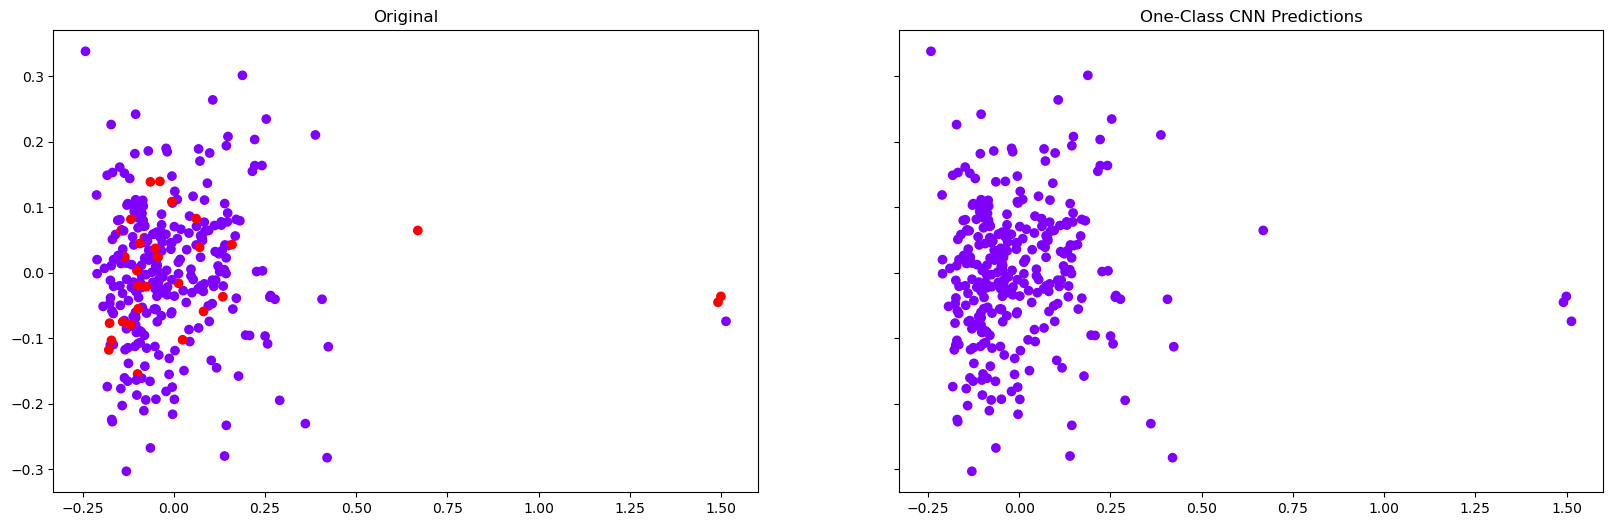

In [27]:
#Visualize the actual and predicted anomalies
fig, (ax0, ax1)= plt.subplots(1,2, sharey=True, figsize=(20,6) )

#Ground truth 
ax0.set_title('Original')
ax0.scatter(df['Feature 1'], df['Feature 2'], c=df['Binary Label'], cmap='rainbow')


#One-Class SVM Predictions
ax1.set_title('One-Class CNN Predictions')
ax1.scatter(df['Feature 1'], df['Feature 2'], c=df['one_class_cnn_prediction'], cmap='rainbow')

